In [1]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt

print("Hello world.")

2025-12-06 04:43:37.315894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764996217.543220      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764996217.620944      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Hello world.


In [2]:
import os
import json
import numpy as np
import cv2

def create_mask(json_file, image_shape):
    if json_file is None or not os.path.exists(json_file):
        return None
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except:
        return None
    if 'shapes' not in data or data['shapes'] is None:
        return None

    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    try:
        for shape in data['shapes']:
            points = np.array(shape.get('points', []), dtype=np.int32)
            if len(points) > 2:
                cv2.fillPoly(mask, [points], 255)
    except:
        return None

    return mask


def find_image_file(base_name, image_path):
    """Find the correct image file (.jpg, .JPG, .jpeg, .JPEG, .png)"""
    exts = [".jpg", ".JPG", ".jpeg", ".JPEG", ".png"]
    for ext in exts:
        file_path = os.path.join(image_path, base_name + ext)
        if os.path.exists(file_path):
            return file_path
    return None

print("Hello world")

Hello world


In [3]:



train_images, valid_images, test_images,   = [], [], []
train_masks, valid_masks, test_masks = [], [] , []


image_path = "/kaggle/input/malabar-dataset/Malabar_Dataset/Anthracnose(102)"
json_path = "/kaggle/input/affected-region-json-files/annotated_json_files/Anthracnose(102)/affected_region"


for i in range(0, len(os.listdir(image_path))):

    base_name = f"Anthracnose ({i+1})"

    json_file = os.path.join(json_path, base_name + ".json")

    # --- FIND REAL IMAGE FILE ---
    image_file = find_image_file(base_name, image_path)
    if image_file is None:
        print(f"Image missing: {base_name}")
        continue

    image = cv2.imread(image_file)
    if image is None:
        print(f"Failed to read: {image_file}")
        continue

    mask = create_mask(json_file, image.shape)
    if mask is None:
        print(f"Mask skipped: {json_file}")
        continue

    if i < 80:
        train_images.append(image)
        train_masks.append(mask)
    elif i < 90:
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)
        

print("Done.")


Done.


In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array

X_train, y_train = preprocess_data(train_images, train_masks)
X_valid, y_valid = preprocess_data(valid_images, valid_masks)
X_test, y_test = preprocess_data(test_images, test_masks)
print("Hello world.")

Hello world.


In [5]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Load model and predict
best_model = load_model("/kaggle/input/temp-testing-dataset/unet_best_model.keras")
predictions = best_model.predict(X_test)

# Create masks from predictions
predicted_masks = create_mask(predictions)

2025-12-06 04:44:08.264961: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1764996249.162869      97 service.cc:148] XLA service 0x7acff800a070 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764996249.163381      97 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1764996249.641422      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [6]:
"""
def visualize_results(images, masks, predictions, num_images=5):
    for i in range(0, num_images):
        img = images[i]
        true_mask = masks[i]
        predicted_mask = predictions[i]
    

        plt.figure(figsize=(20, 5))  # wider figure for 4 plots

        # 1. Original Image
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # 2. Ground Truth Mask
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # 3. Predicted Mask
        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

   
        plt.show()

# Visualize results
visualize_results(X_test, y_test, predicted_masks, num_images=5)
"""

print("Hello world.")


Hello world.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
"""
def visualize_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        img = images[i]
        true_mask = masks[i]
        predicted_mask = predictions[i]

        # Ensure mask is binary (0 or 1)
        predicted_mask_bin = (predicted_mask.squeeze() > 0.5).astype(np.uint8)  # thresholding

        # Apply mask to original image
        segmented_img = cv2.bitwise_and(img, img, mask=predicted_mask_bin)

        plt.figure(figsize=(25, 5))  # wider figure for 4 plots

        # 1. Original Image
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # 2. Ground Truth Mask
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # 3. Predicted Mask
        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        # 4. Segmented Image
        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title('Segmented Image')
        plt.axis('off')

        plt.show()


visualize_results(X_test, y_test, predicted_masks, num_images=5)
"""
print("Hello world.")

Hello world.


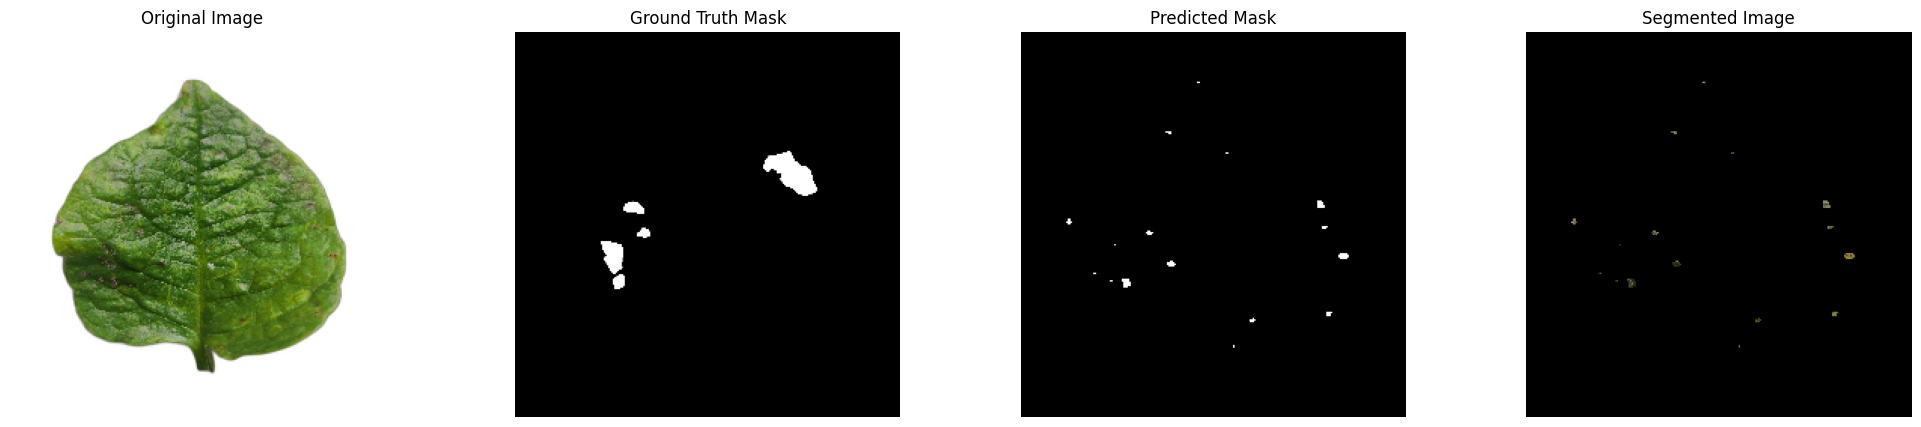

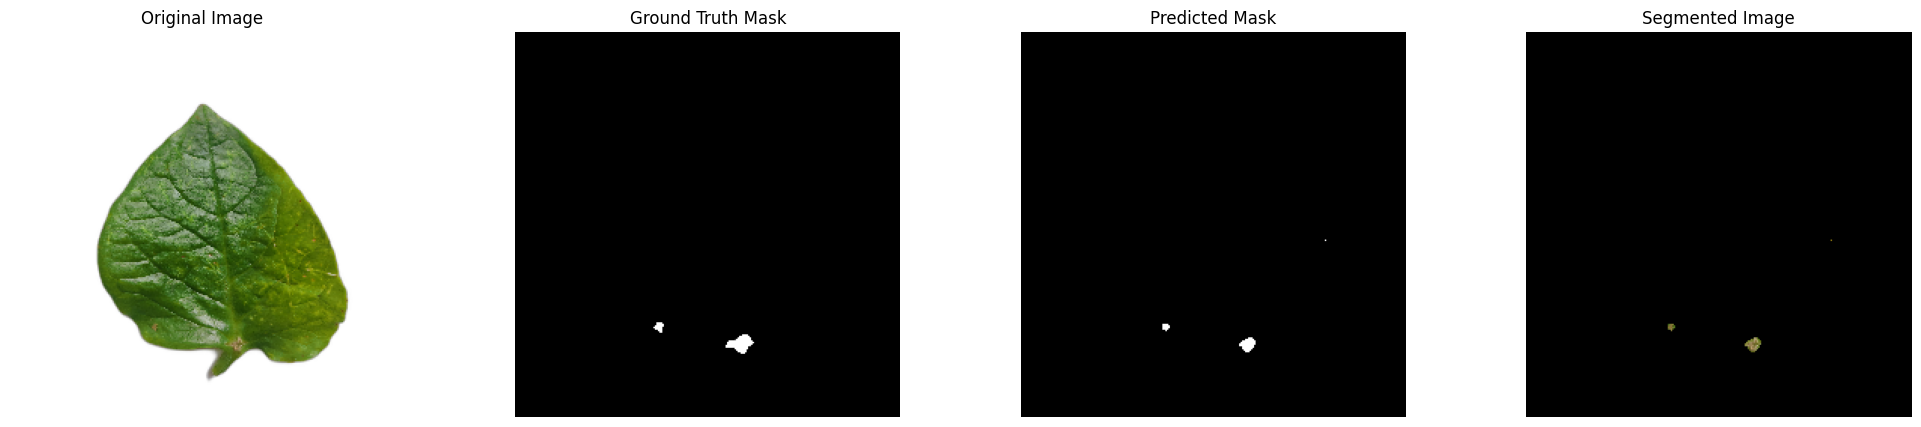

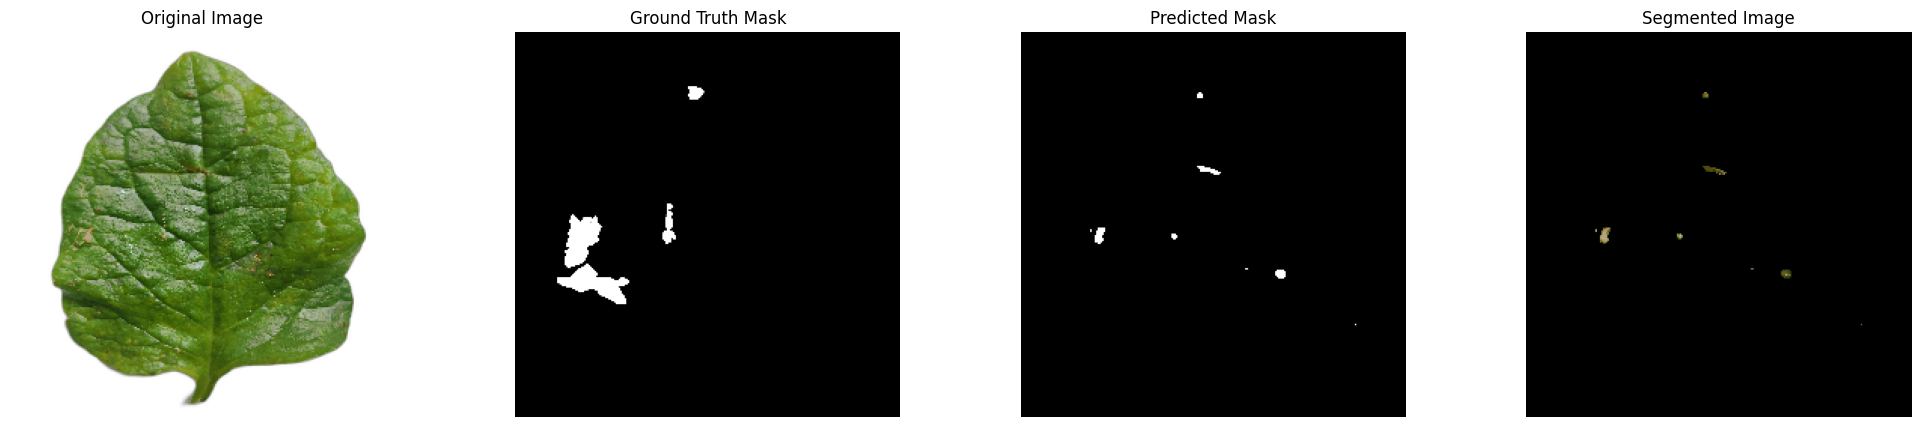

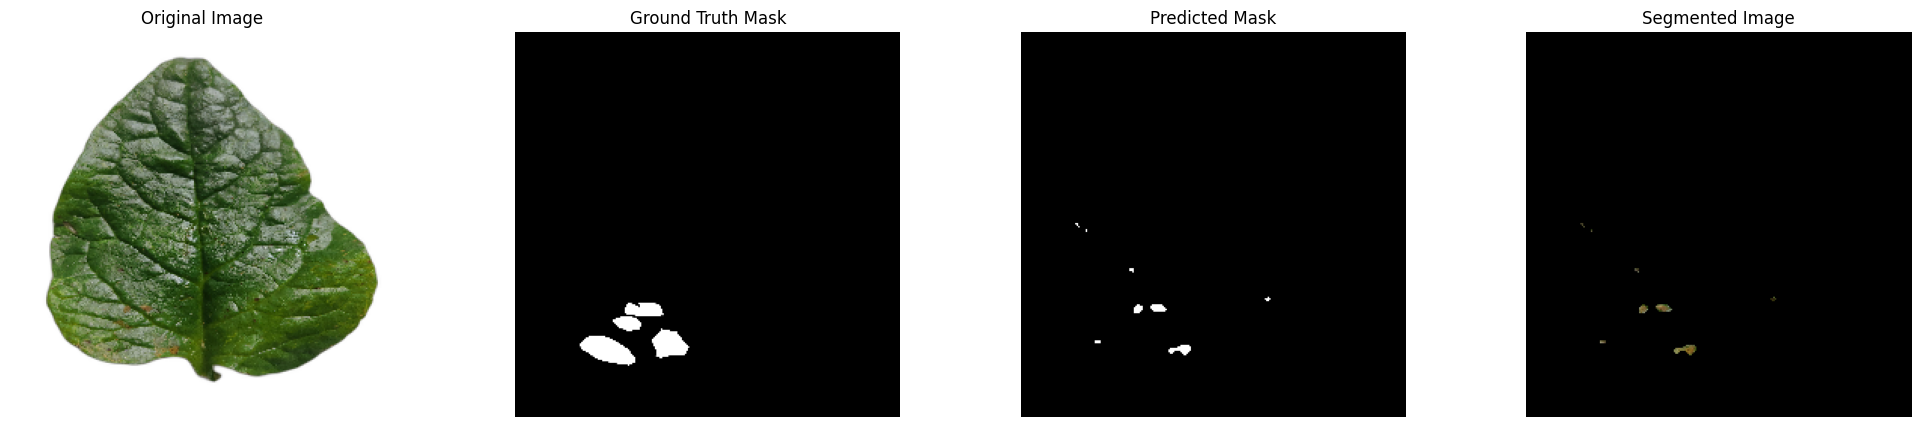

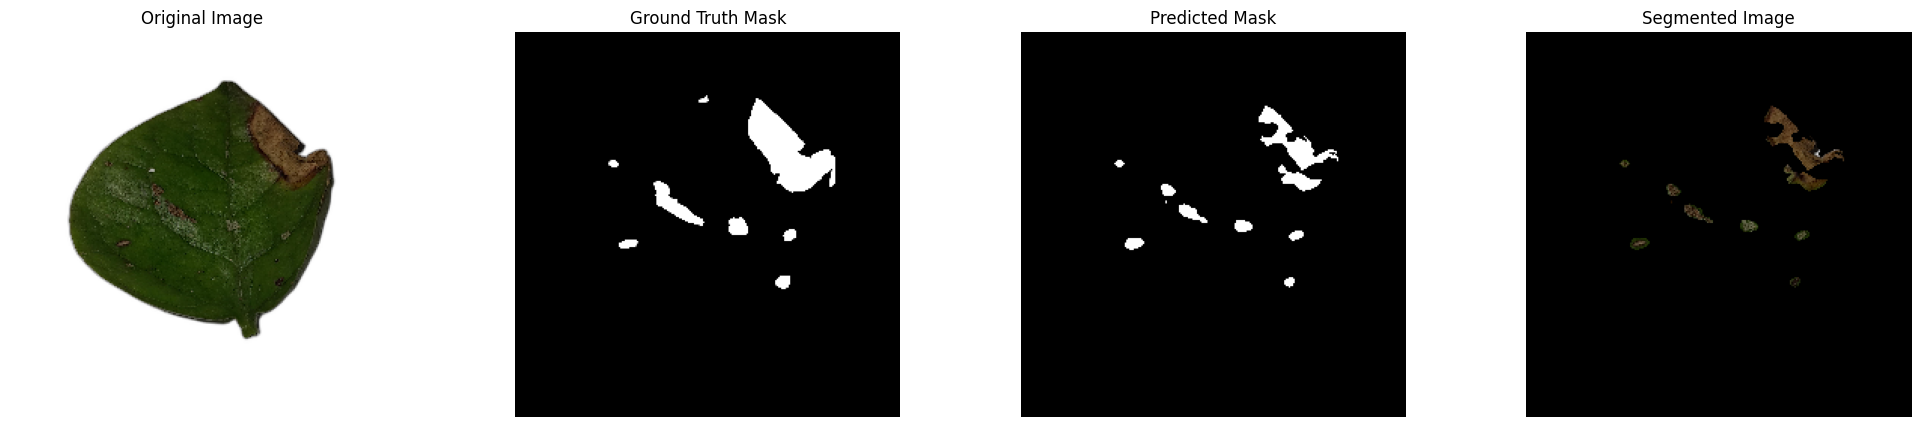

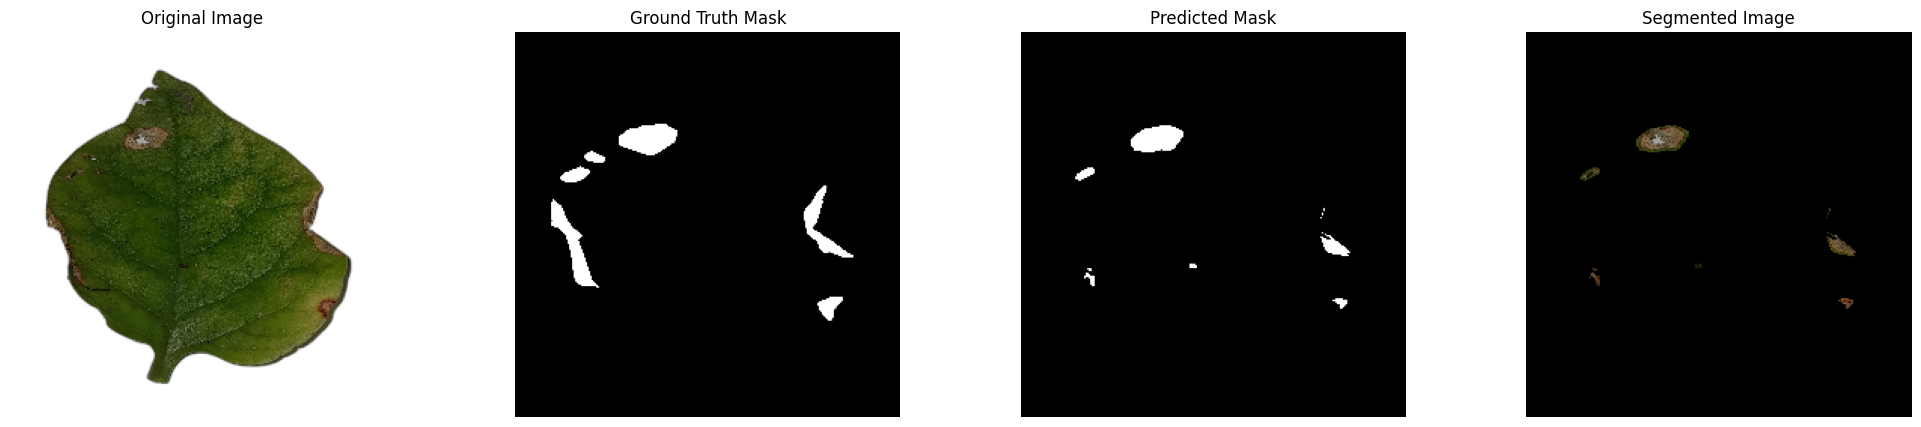

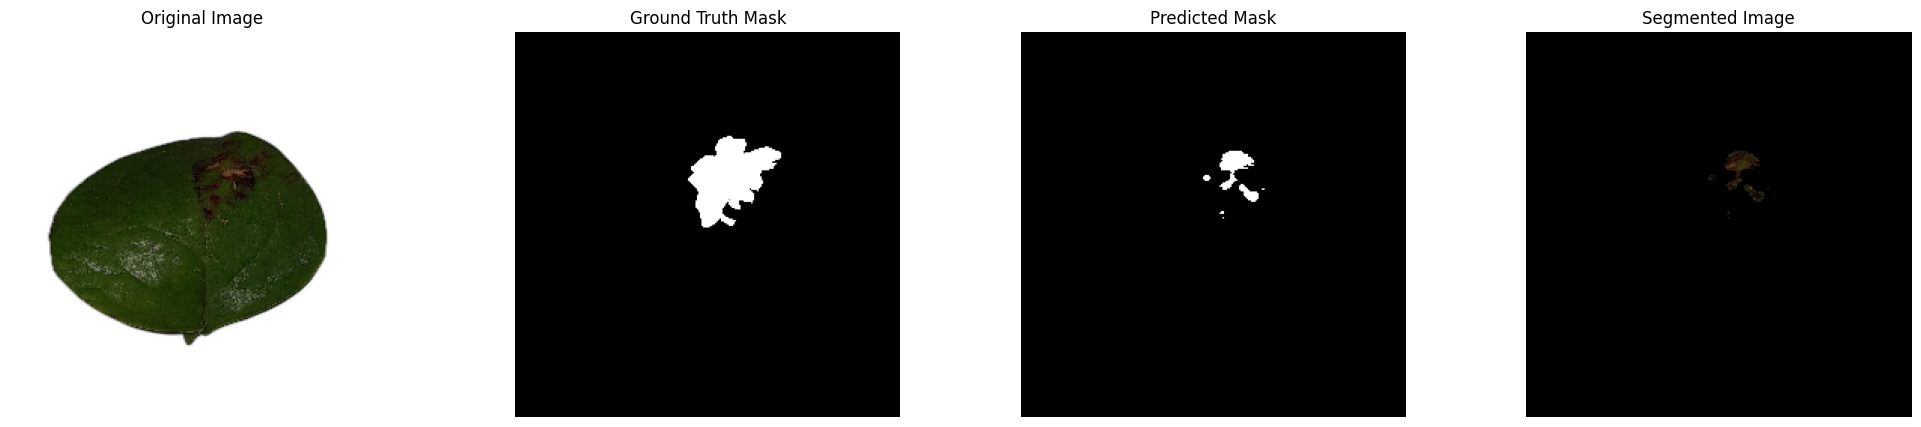

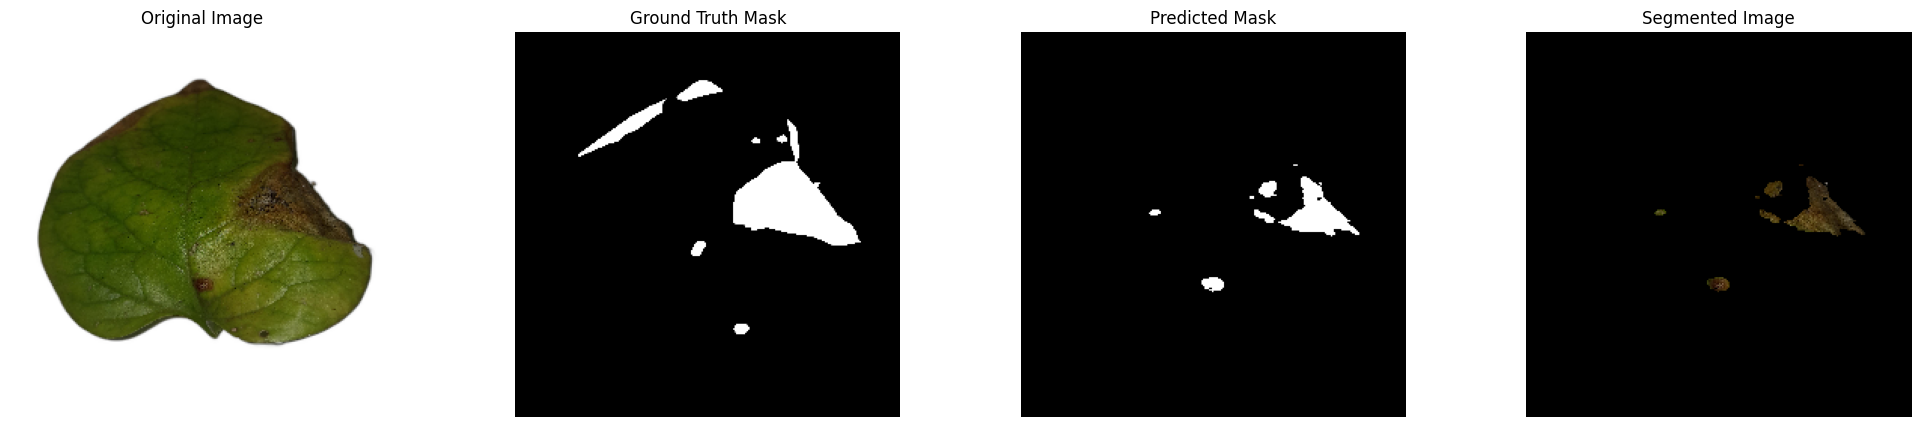

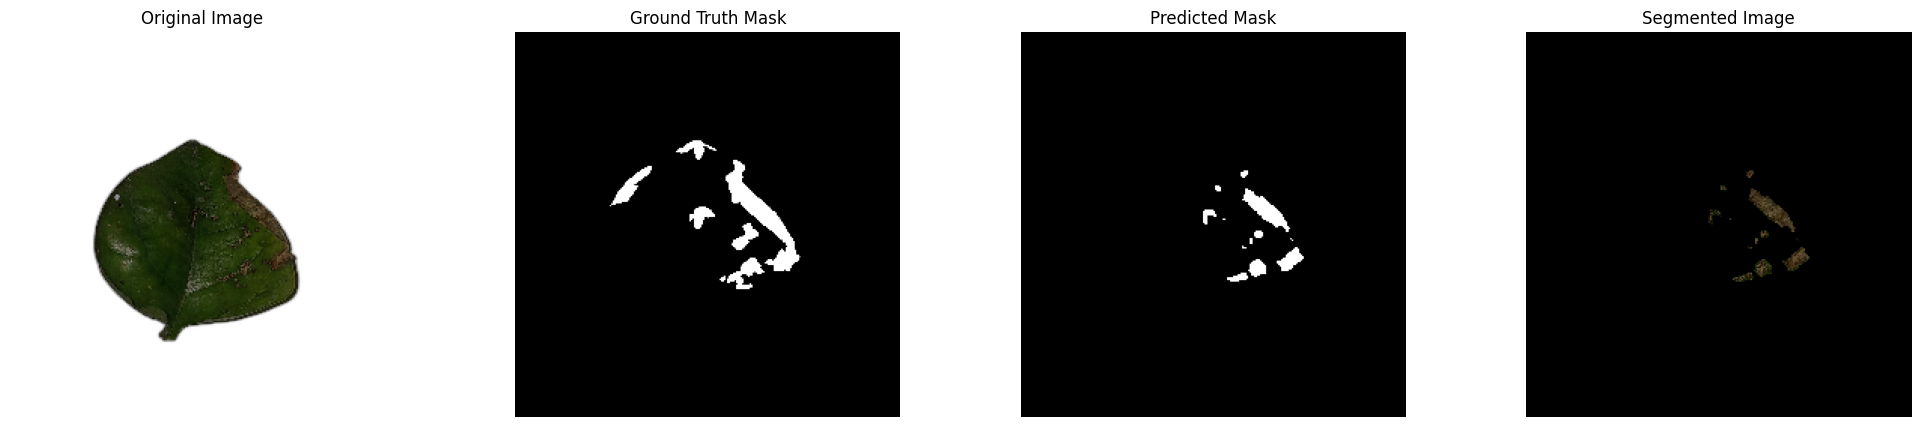

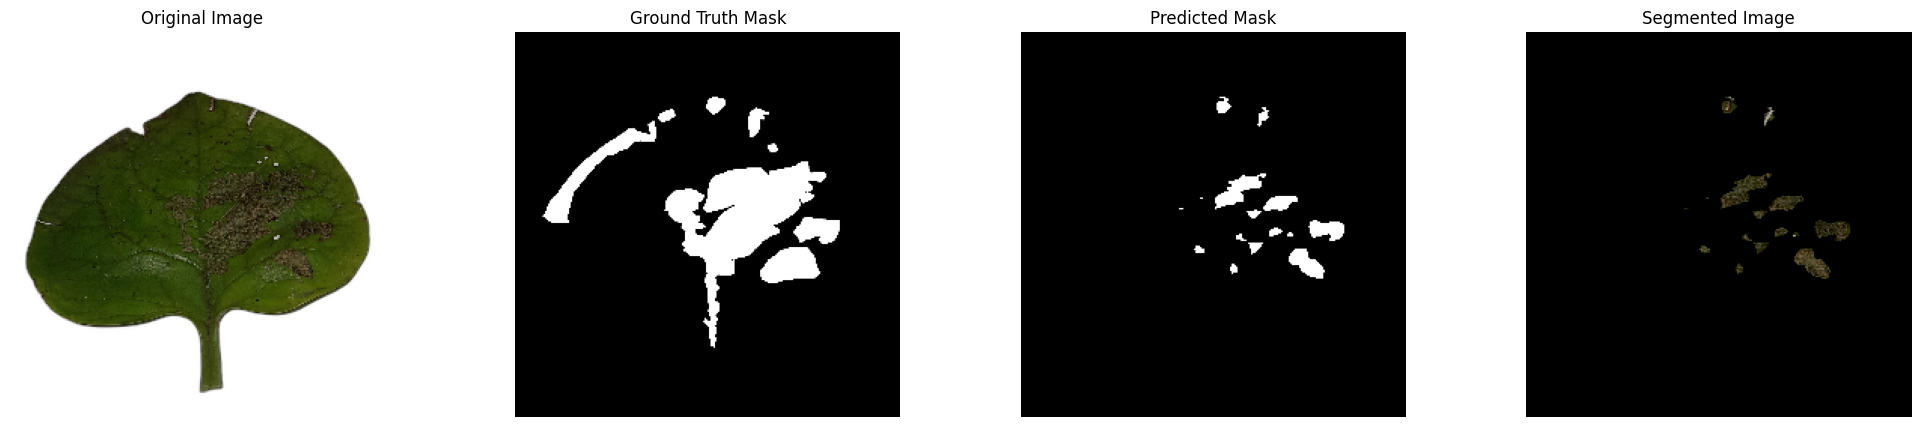

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_and_save_results(images, masks, predictions,  
                               mask_folder='predicted_masks', 
                               segmented_folder='segmented_images'):
    
    # Create folders if they don't exist
    os.makedirs(mask_folder, exist_ok=True)
    os.makedirs(segmented_folder, exist_ok=True)
    
    for i in range(10):
        img = images[i]
        true_mask = masks[i]
        predicted_mask = predictions[i]

        # Convert predicted mask to binary
        predicted_mask_bin = (predicted_mask.squeeze() > 0.5).astype(np.uint8) * 255
        if len(predicted_mask_bin.shape) == 3:
            predicted_mask_bin = predicted_mask_bin[:, :, 0]

        img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        # Save predicted mask
        mask_path = os.path.join(mask_folder, f'pred_mask_{i}.png')
        cv2.imwrite(mask_path, predicted_mask_bin)

        # Apply mask to original image to get segmented image
        segmented_img = cv2.bitwise_and(img_uint8, img_uint8, mask=predicted_mask_bin)

        # Save segmented image
        segmented_path = os.path.join(segmented_folder, f'segmented_{i}.png')
        cv2.imwrite(segmented_path, segmented_img)  # save in RGB format

        # Visualization
        plt.figure(figsize=(25, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title('Segmented Image')
        plt.axis('off')

        plt.show()

# Example usage
visualize_and_save_results(X_test, y_test, predicted_masks)


In [ ]:
while(True):
    i = 0